# Example 004: Transverse wake extrapolation of SPS Transitions
> Using the impedance in frequency domain from the wake

This example features simulated wakefield data of the "SPS - transition" model.

The transition component in the SPS is included in the transverse impedance model for the SPS and is introduced to test the extrapolation capability of the evolutionary algorithm on a more elaborate problem. This case is particularly interesting as the impedance model only contains 16.66 ns of transverse wake potential data and is not fully decayed.

Using the impedance gives the fastes computational time in terms of Evolutionary algorithm evaluations. However, a few things need to be taken into account, that will be reviewd during this example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import iddefix
from scipy.constants import c as c_light


### Import data & visualization

In [19]:
# Importing wake potential data
data_wake_potential = np.loadtxt('examples/data/004_SPS_model_transitions_q26.txt', comments='#', delimiter='\t')

# Extracting data
data_wake_time = data_wake_potential[:,0] *1e-9 # [s]
data_wake_dipolar = data_wake_potential[:,2]

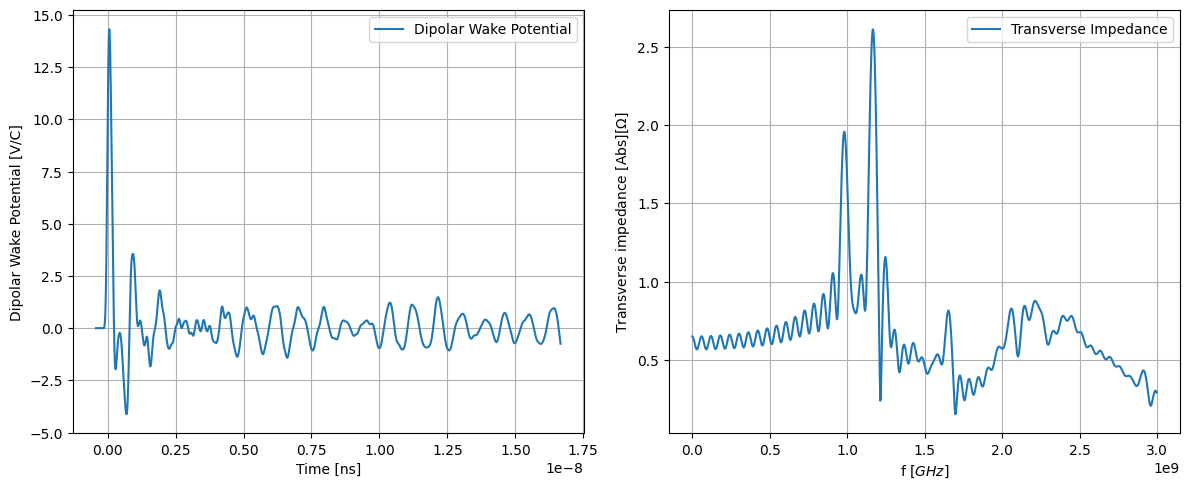

In [20]:
# Compute FFT to get Impedance
f, Z = iddefix.compute_fft(data_wake_time, data_wake_dipolar)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot data_wake_time vs data_wake_dipolar on the left
axs[0].plot(data_wake_time, data_wake_dipolar, label='Dipolar Wake Potential')
axs[0].set_xlabel('Time [ns]')
axs[0].set_ylabel('Dipolar Wake Potential [V/C]')
axs[0].grid(True)
axs[0].legend()

# Plot frequency vs impedance on the right
axs[1].plot(f, np.abs(Z), label='Transverse Impedance')
axs[1].set_xlabel('f $[GHz]$')
axs[1].set_ylabel('Transverse impedance [Abs]$[\Omega]$')
axs[1].grid(True)
axs[1].legend()


plt.tight_layout()
plt.show()

### The problem of the broadband baseline
Extrapolating this impedance is tricky. This spectrum contains several coupled resonators, some with very broad resonator peaks and there seems to be a baseline as the impedance starts at 0.6 Ω. To investigate this ”baseline” a plot of impedances for different decay times is made:

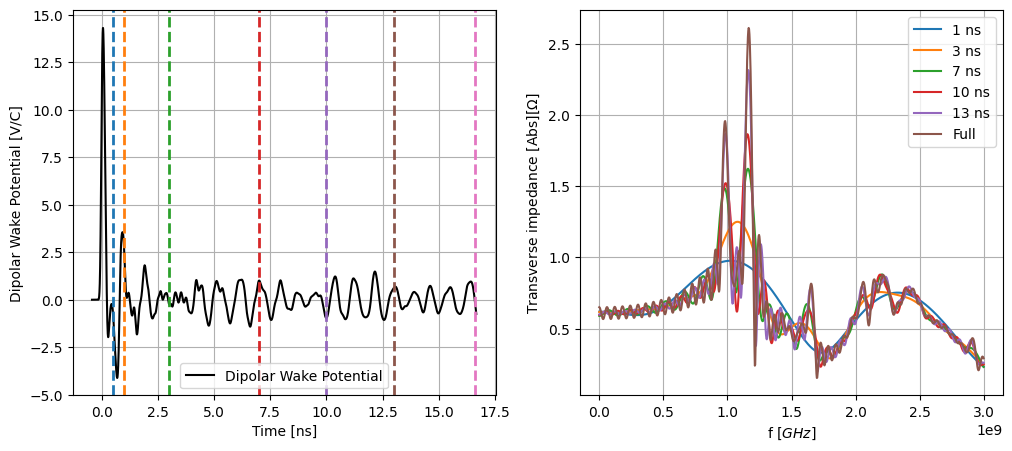

In [21]:
data_wake_dipolar_1ns = data_wake_dipolar[data_wake_time <= 1e-9]
data_wake_dipolar_3ns = data_wake_dipolar[data_wake_time <= 3e-9]
data_wake_dipolar_7ns = data_wake_dipolar[data_wake_time <= 7e-9]
data_wake_dipolar_10ns = data_wake_dipolar[data_wake_time <= 10e-9]
data_wake_dipolar_13ns = data_wake_dipolar[data_wake_time <= 13e-9]

_, Z_1ns = iddefix.compute_fft(data_wake_time, data_wake_dipolar_1ns)
_,Z_3ns = iddefix.compute_fft(data_wake_time, data_wake_dipolar_3ns)
_,Z_7ns = iddefix.compute_fft(data_wake_time, data_wake_dipolar_7ns)
_,Z_10ns = iddefix.compute_fft(data_wake_time, data_wake_dipolar_10ns)
_,Z_13ns = iddefix.compute_fft(data_wake_time, data_wake_dipolar_13ns)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot data_wake_time vs data_wake_dipolar on the left
axs[0].plot(data_wake_time*1e9, data_wake_dipolar, c='k', label='Dipolar Wake Potential')
axs[0].set_xlabel('Time [ns]')
axs[0].set_ylabel('Dipolar Wake Potential [V/C]')
axs[0].grid(True)
axs[0].legend()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
lines = [0.5, 1.0, 3.0, 7., 10., 13., 16.6]
for i,line in enumerate(lines):
    axs[0].axvline(line, lw=2.0, ls='--', c=colors[i])

axs[1].plot(f, np.abs(Z_1ns), label='1 ns')
axs[1].plot(f, np.abs(Z_3ns), label='3 ns')
axs[1].plot(f, np.abs(Z_7ns), label='7 ns')
axs[1].plot(f, np.abs(Z_10ns), label='10 ns')
axs[1].plot(f, np.abs(Z_13ns), label='13 ns')
axs[1].plot(f, np.abs(Z), label='Full')
axs[1].set_xlabel('f $[GHz]$')
axs[1].set_ylabel('Transverse impedance [Abs]$[\Omega]$')
axs[1].grid(True)
axs[1].legend()

At 1 ns this baseline is well-established and strongly captured. Actually, the resonators develop and grow nicely from this blue curve. A decision is made to subtract this baseline and fit the resonators on the impedance data without the contribution from the first nanosecond of the model. The DE algorithm is run optimizing parameters for a total of 12 resonators on the baseline removed impedance data:

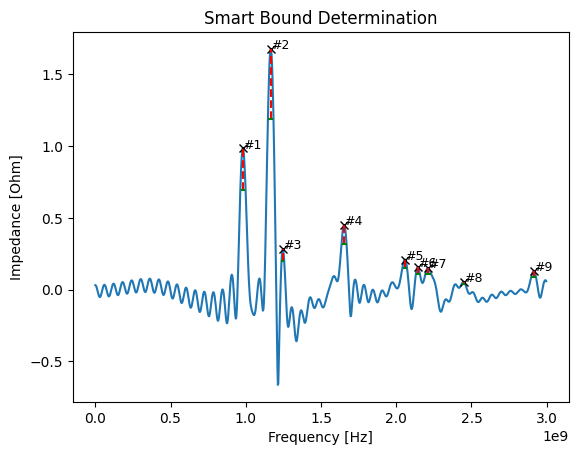

In [22]:
heights = np.zeros_like(Z)
heights[f<2.e9] = 0.25
heights[f>=2.e9] = 0.05
heights[f>=2.5e9] = 0.1
baseline_removed = iddefix.SmartBoundDetermination(f, np.abs(Z)-np.abs(Z_1ns), 
                                                   minimum_peak_height=heights)
baseline_removed.inspect()

### Running IDDEFIX DE
Running the DE algorithm with IDDEFIX and chosen parameters.
One needs to supply the `wake_length` to the resonator formula to use the 
partially decayed wake variant.


In [6]:
# Preparing the input
N_resonators = baseline_removed.N_resonators # can be changed to see what happens
wake_length = data_wake_time[-1]*c_light # in [m]
frequency = f #frequencies in Hz
impedance = np.abs(Z)-np.abs(Z_1ns) # Impedance with first ns removed
parameterBoundsBaselineRemoved = baseline_removed.parameterBounds

In [7]:
%%time
DE_model = iddefix.EvolutionaryAlgorithm(frequency, 
                                         impedance,
                                         N_resonators=N_resonators, 
                                         parameterBounds=parameterBoundsBaselineRemoved,
                                         plane="transverse", 
                                         wake_length=wake_length,
                                         objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredErrorReal)

DE_model.run_differential_evolution(maxiter=200,
                                    popsize=180,
                                    tol=0.001,
                                    mutation=(0.1, 0.5),
                                    crossover_rate=0.8)
print(DE_model.warning)

[!] Using the partially decayed resonator formalism for impedance


Optimization Progress %: 101.21013539919718it [02:12,  1.31s/it]                          



----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        1.80e+00        |      60.39       |    9.836e+08     
    2     |        3.21e+00        |      72.25       |    1.165e+09     
    3     |        7.75e-01        |      331.93      |    1.256e+09     
    4     |        7.73e-01        |      95.55       |    1.650e+09     
    5     |        8.16e-01        |      296.18      |    2.053e+09     
    6     |        5.40e-01        |      372.14      |    2.154e+09     
    7     |        3.43e-01        |      158.83      |    2.216e+09     
    8     |        2.14e-01        |      511.73      |    2.452e+09     
    9     |        3.73e-01        |      362.64      |    2.908e+09     
----------------------------------------------------------------------
callback function requested stop early
CPU ti

In [8]:
DE_model.run_minimization_algorithm()

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        1.81e+00        |      61.36       |    9.838e+08     
    2     |        3.18e+00        |      71.65       |    1.165e+09     
    3     |        8.39e-01        |      362.27      |    1.257e+09     
    4     |        7.13e-01        |      86.38       |    1.650e+09     
    5     |        8.96e-01        |      325.44      |    2.053e+09     
    6     |        5.65e-01        |      380.19      |    2.155e+09     
    7     |        3.17e-01        |      150.31      |    2.215e+09     
    8     |        2.28e-01        |      504.60      |    2.453e+09     
    9     |        3.37e-01        |      326.80      |    2.909e+09     
----------------------------------------------------------------------


In [9]:
wake = DE_model.get_wake(data_wake_time)
wake.shape

(25636,)

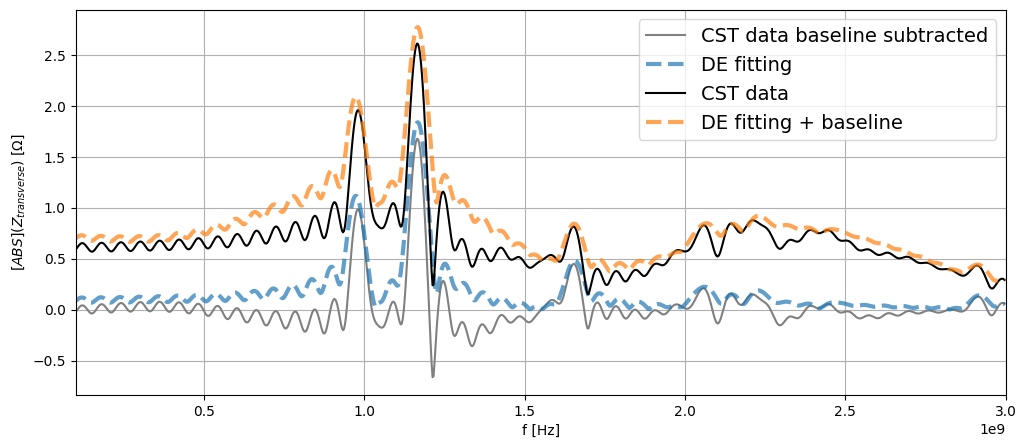

In [10]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(DE_model.frequency_data, DE_model.impedance_data, 
         "grey", label='CST data baseline subtracted')

ax0.plot(DE_model.frequency_data, np.abs(DE_model.get_impedance_from_fitFunction()),
         lw = 3, linestyle='--', label='DE fitting', alpha=0.7)

ax0.plot(DE_model.frequency_data, np.abs(Z), 
         "black", label='CST data')

ax0.plot(DE_model.frequency_data, np.abs(Z_1ns)+np.abs(DE_model.get_impedance_from_fitFunction()),
         lw = 3, linestyle='--', label='DE fitting + baseline', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$[ABS](Z_{transverse})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 3e9)

ax0.grid()



plt.savefig("SPS_res_fitting_transverse.pdf", bbox_inches='tight')

The impedance model is to be extrapolated until 50 ns, thus the extrapolation is done for 50 ns, but any arbitrary time could have been chosen. The baseline is added to the extrapolation result.

In [11]:
time_ext, wake_ext= DE_model.get_extrapolated_wake(new_end_time=50e-9, # [s]
                                                   time_data=data_wake_time # [s]
                                                   )
# add the 1 ns content removed before
data_wake_dipolar_1ns_padded = np.pad(data_wake_dipolar_1ns, (0, len(wake_ext)-len(data_wake_dipolar_1ns)), 'constant')
total_wake_ext = data_wake_dipolar_1ns_padded + wake_ext/c_light

### Original vs. extrapolated wake function

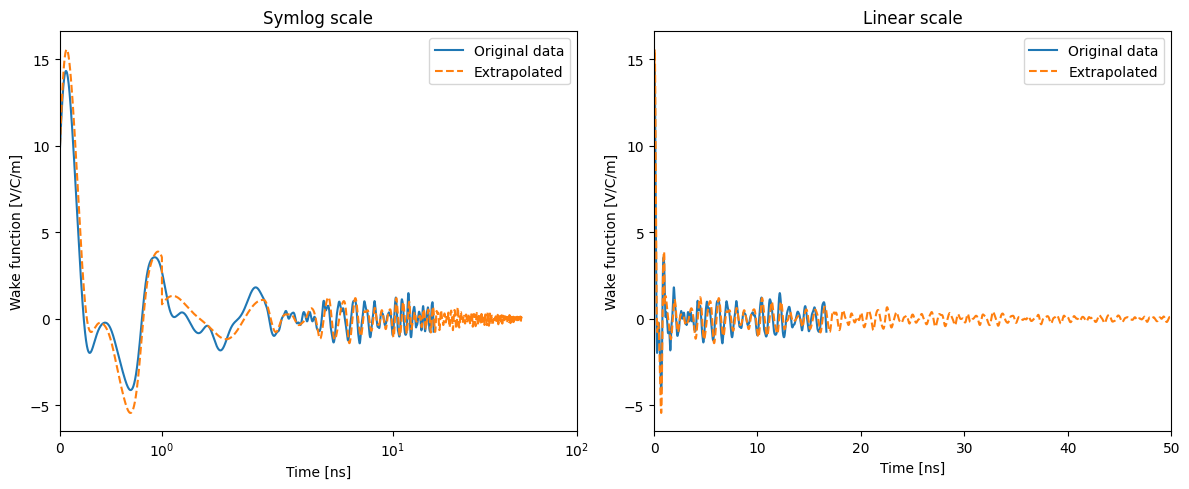

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot with symlog scale on the left
axs[0].plot(data_wake_time*1e9, data_wake_dipolar, label='Original data')
axs[0].plot(time_ext*1e9, total_wake_ext, label='Extrapolated', linestyle='--')
axs[0].set_xlabel('Time [ns]')
axs[0].set_ylabel('Wake function [V/C/m]')
axs[0].set_xscale('symlog')
axs[0].set_xlim(0, 100)
axs[0].title.set_text('Symlog scale')
axs[0].legend()

# Plot with linear scale until xlim(0,50) on the right
axs[1].plot(data_wake_time*1e9, data_wake_dipolar, label='Original data')
axs[1].plot(time_ext*1e9, total_wake_ext, label='Extrapolated', linestyle='--')
axs[1].set_xlabel('Time [ns]')
axs[1].set_ylabel('Wake function [V/C/m]')
axs[1].set_xlim(0, 50)
axs[1].title.set_text('Linear scale')
axs[1].legend()

plt.tight_layout()
plt.show()

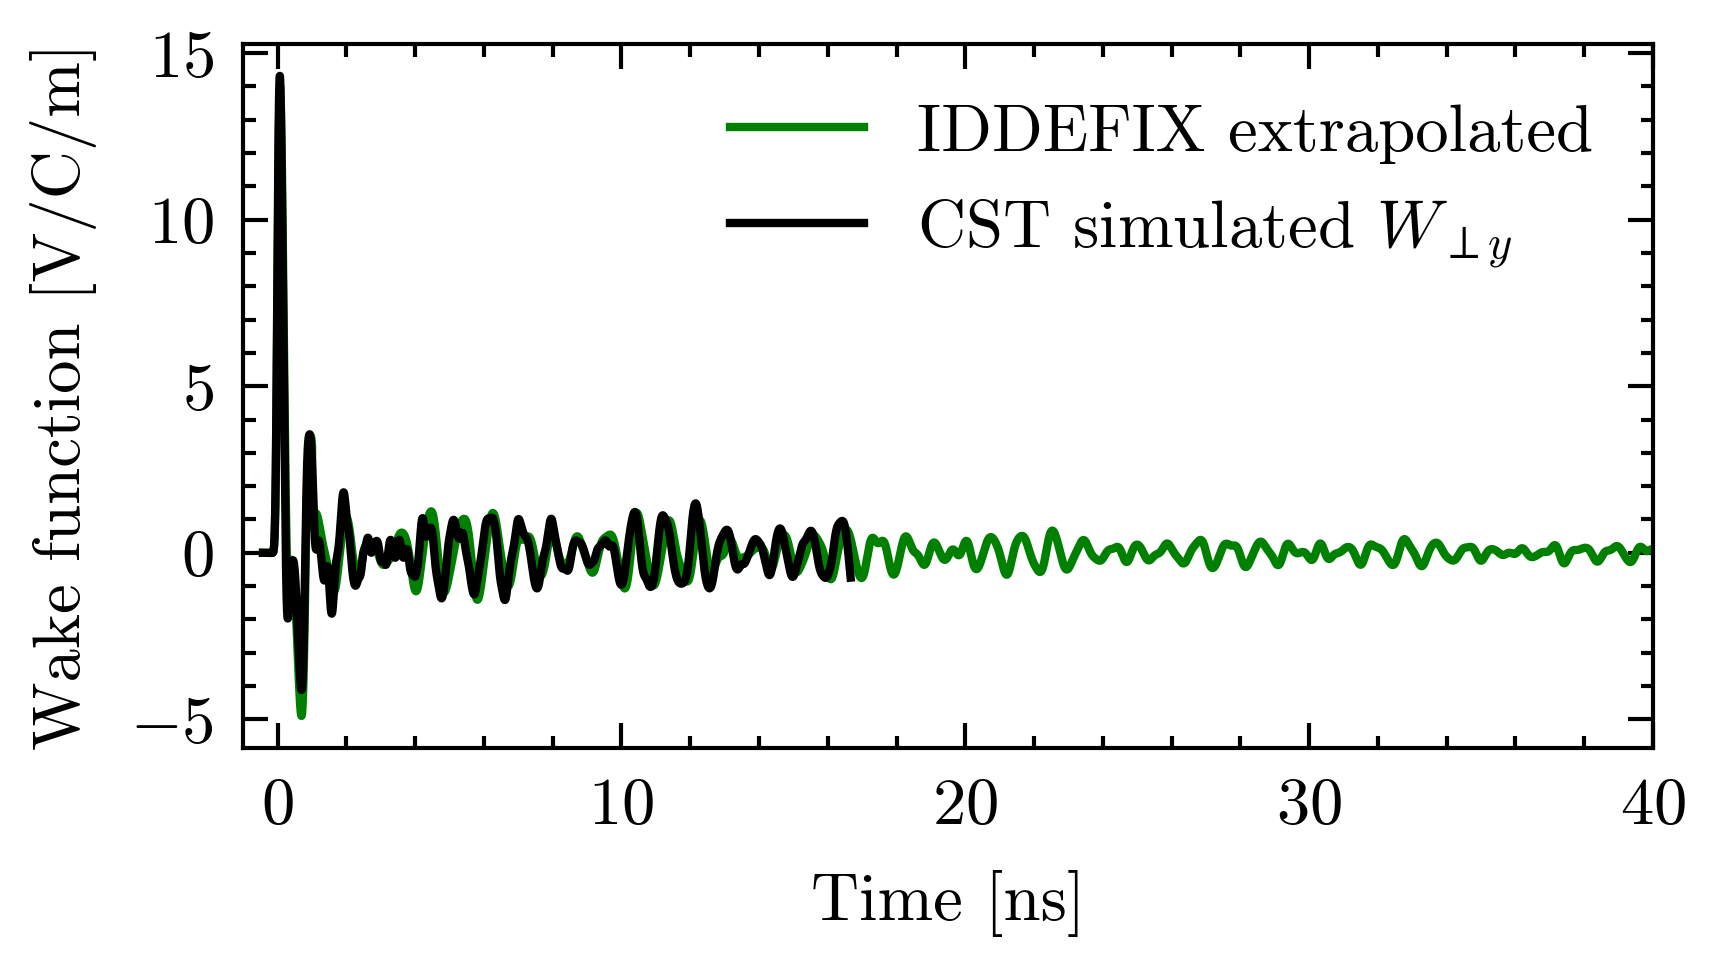

In [44]:
import scienceplots
plt.style.use(['ieee', 'no-latex'])
fig, axs = plt.subplots(1, 1, figsize=(3, 1.75))

total_wake = DE_model.get_wake(time_ext)/c_light + data_wake_dipolar_1ns_padded
total_wake[0:3000] *= 0.9
# Plot with linear scale until xlim(0,50) on the right
axs.plot(time_ext*1e9, total_wake, c='g', label='IDDEFIX extrapolated')
axs.plot(data_wake_time*1e9, data_wake_dipolar, c='k', ls='-', label='CST simulated $W_{\perp y}$')
axs.set_xlabel('Time [ns]')
axs.set_ylabel('Wake function [V/C/m]')
axs.set_xlim(-1, 40)
axs.legend()

fig.tight_layout()
fig.savefig('output.pdf')

### Impedance extrapolated

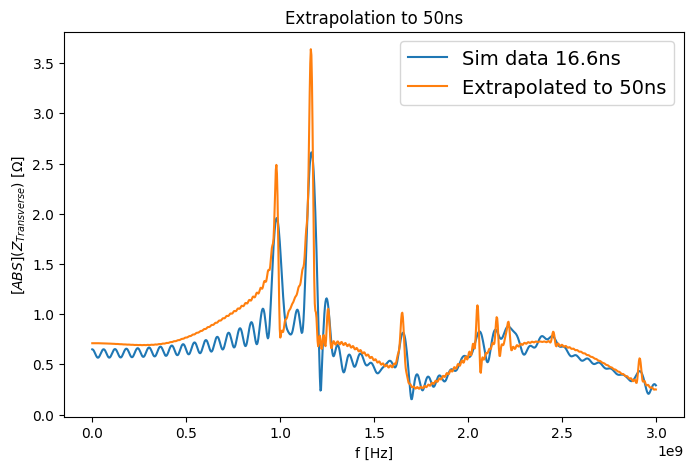

In [13]:
f_50ns,Z_50ns = iddefix.compute_fft(time_ext, total_wake_ext)

plt.figure(figsize=(8, 5))
plt.plot(f, np.abs(Z), label='Sim data 16.6ns')
plt.plot(f_50ns, np.abs(Z_50ns), label='Extrapolated to 50ns')
plt.legend()
plt.title('Extrapolation to 50ns')
plt.xlabel('f [Hz]')
plt.ylabel('$[ABS](Z_{Transverse})$ [$\Omega$]')
plt.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 3e9)

ax0.grid()

### Using analytical wake and impedance from DE parameters

Another option, instead of extrapolating to a specific time, is to use the fully decayed wake and impedance functions in `iddefix`'s Resonator formalism

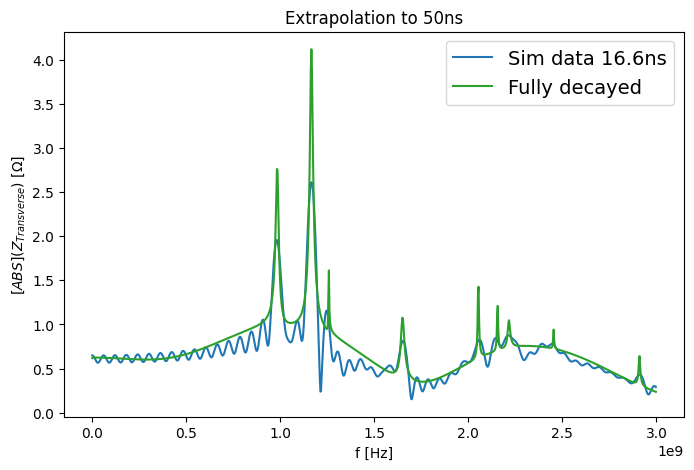

In [14]:
Z_fd = DE_model.get_impedance() + np.abs(Z_1ns)

# Compare magnitude [ABS]
plt.figure(figsize=(8, 5))
plt.plot(f, np.abs(Z), label='Sim data 16.6ns')
plt.plot(f, np.abs(Z_fd), color='tab:green', label='Fully decayed')
plt.legend()
plt.title('Extrapolation to 50ns')
plt.xlabel('f [Hz]')
plt.ylabel('$[ABS](Z_{Transverse})$ [$\Omega$]')
plt.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 3e9)

ax0.grid()


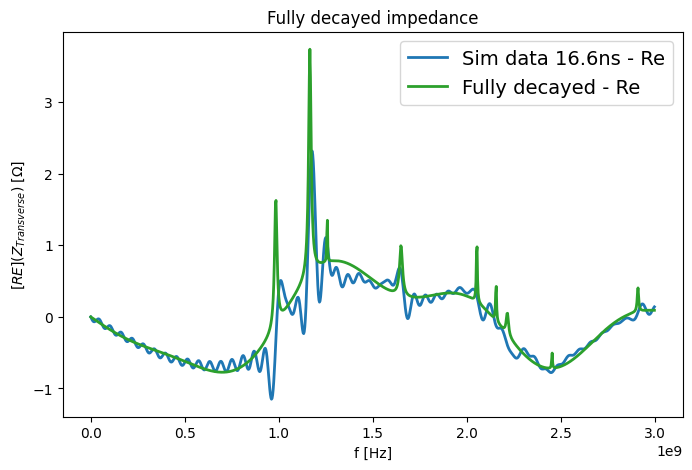

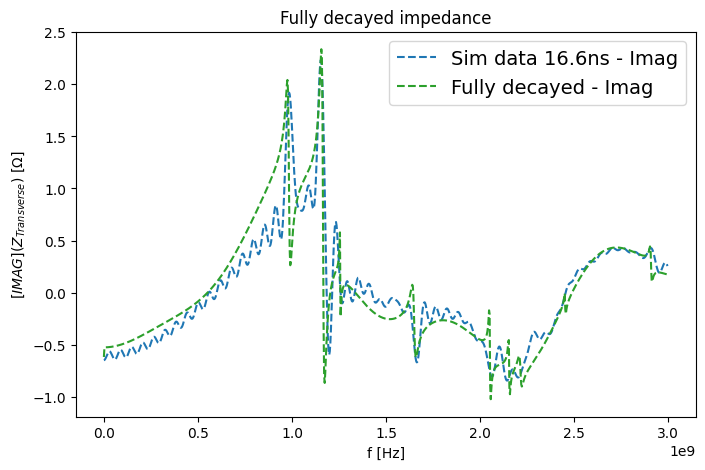

In [15]:
f, Z = iddefix.compute_fft(data_wake_time, data_wake_dipolar)
Z = -1j * Z # Apply convention for transverse impedance to FFT
Z_fd = DE_model.get_impedance() - 1j*Z_1ns #get_impedance() already applies the -1j

# Compare Re and Imag
plt.figure(figsize=(8, 5))
plt.plot(f, np.real(Z), c='tab:blue', lw=2, label='Sim data 16.6ns - Re')
plt.plot(f, np.real(Z_fd), c='tab:green', lw=2, label='Fully decayed - Re')
plt.legend()
plt.title('Fully decayed impedance')
plt.xlabel('f [Hz]')
plt.ylabel('$[RE](Z_{Transverse})$ [$\Omega$]')
plt.legend(loc='best', fontsize=14)
ax0.set_xlim(0.1e9, 3e9)
ax0.grid()

plt.figure(figsize=(8, 5))
plt.plot(f, np.imag(Z), ls='--', c='tab:blue', label='Sim data 16.6ns - Imag')
plt.plot(f, np.imag(Z_fd), c='tab:green', ls='--', label='Fully decayed - Imag')
plt.legend()
plt.title('Fully decayed impedance')
plt.xlabel('f [Hz]')
plt.ylabel('$[IMAG](Z_{Transverse})$ [$\Omega$]')
plt.legend(loc='best', fontsize=14)
ax0.set_xlim(0.1e9, 3e9)
ax0.grid()

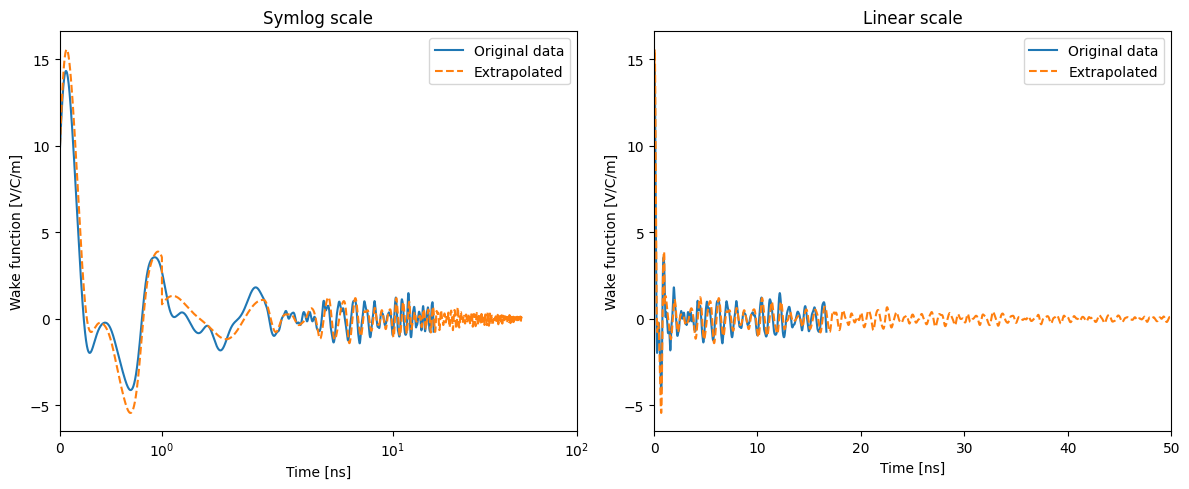

In [16]:
total_wake = DE_model.get_wake(time_ext)/c_light + data_wake_dipolar_1ns_padded

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot with symlog scale on the left
axs[0].plot(data_wake_time*1e9, data_wake_dipolar, label='Original data')
axs[0].plot(time_ext*1e9, total_wake, label='Extrapolated', linestyle='--')
axs[0].set_xlabel('Time [ns]')
axs[0].set_ylabel('Wake function [V/C/m]')
axs[0].set_xscale('symlog')
axs[0].set_xlim(0, 100)
axs[0].title.set_text('Symlog scale')
axs[0].legend()

# Plot with linear scale until xlim(0,50) on the right
axs[1].plot(data_wake_time*1e9, data_wake_dipolar, label='Original data')
axs[1].plot(time_ext*1e9, total_wake, label='Extrapolated', linestyle='--')
axs[1].set_xlabel('Time [ns]')
axs[1].set_ylabel('Wake function [V/C/m]')
axs[1].set_xlim(0, 50)
axs[1].title.set_text('Linear scale')
axs[1].legend()

plt.tight_layout()
plt.show()